In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVR
from sklearn.kernel_approximation import RBFSampler, PolynomialCountSketch
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
#census_hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/census_hourly_h3.csv")
#census_2hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/census_2hourly_h3.csv")
#census_6hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/census_6hourly_h3.csv")
#census_12hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/census_12hourly_h3.csv")

area_hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/area_hourly_h3.csv")
area_2hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/area_2hourly_h3.csv")
area_6hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/area_6hourly_h3.csv")
area_12hourly_h3 = pd.read_csv("/content/drive/MyDrive/Triple A/data/area_12hourly_h3.csv")

datasets = {
    #"census_hourly_h3": census_hourly_h3,
    #"census_2hourly_h3": census_2hourly_h3,
    #"census_6hourly_h3": census_6hourly_h3,
    #"census_12hourly_h3": census_12hourly_h3,
    "area_2hourly_h3": area_2hourly_h3,
    "area_6hourly_h3": area_6hourly_h3,
    "area_12hourly_h3": area_12hourly_h3,
    "area_hourly_h3": area_hourly_h3
}

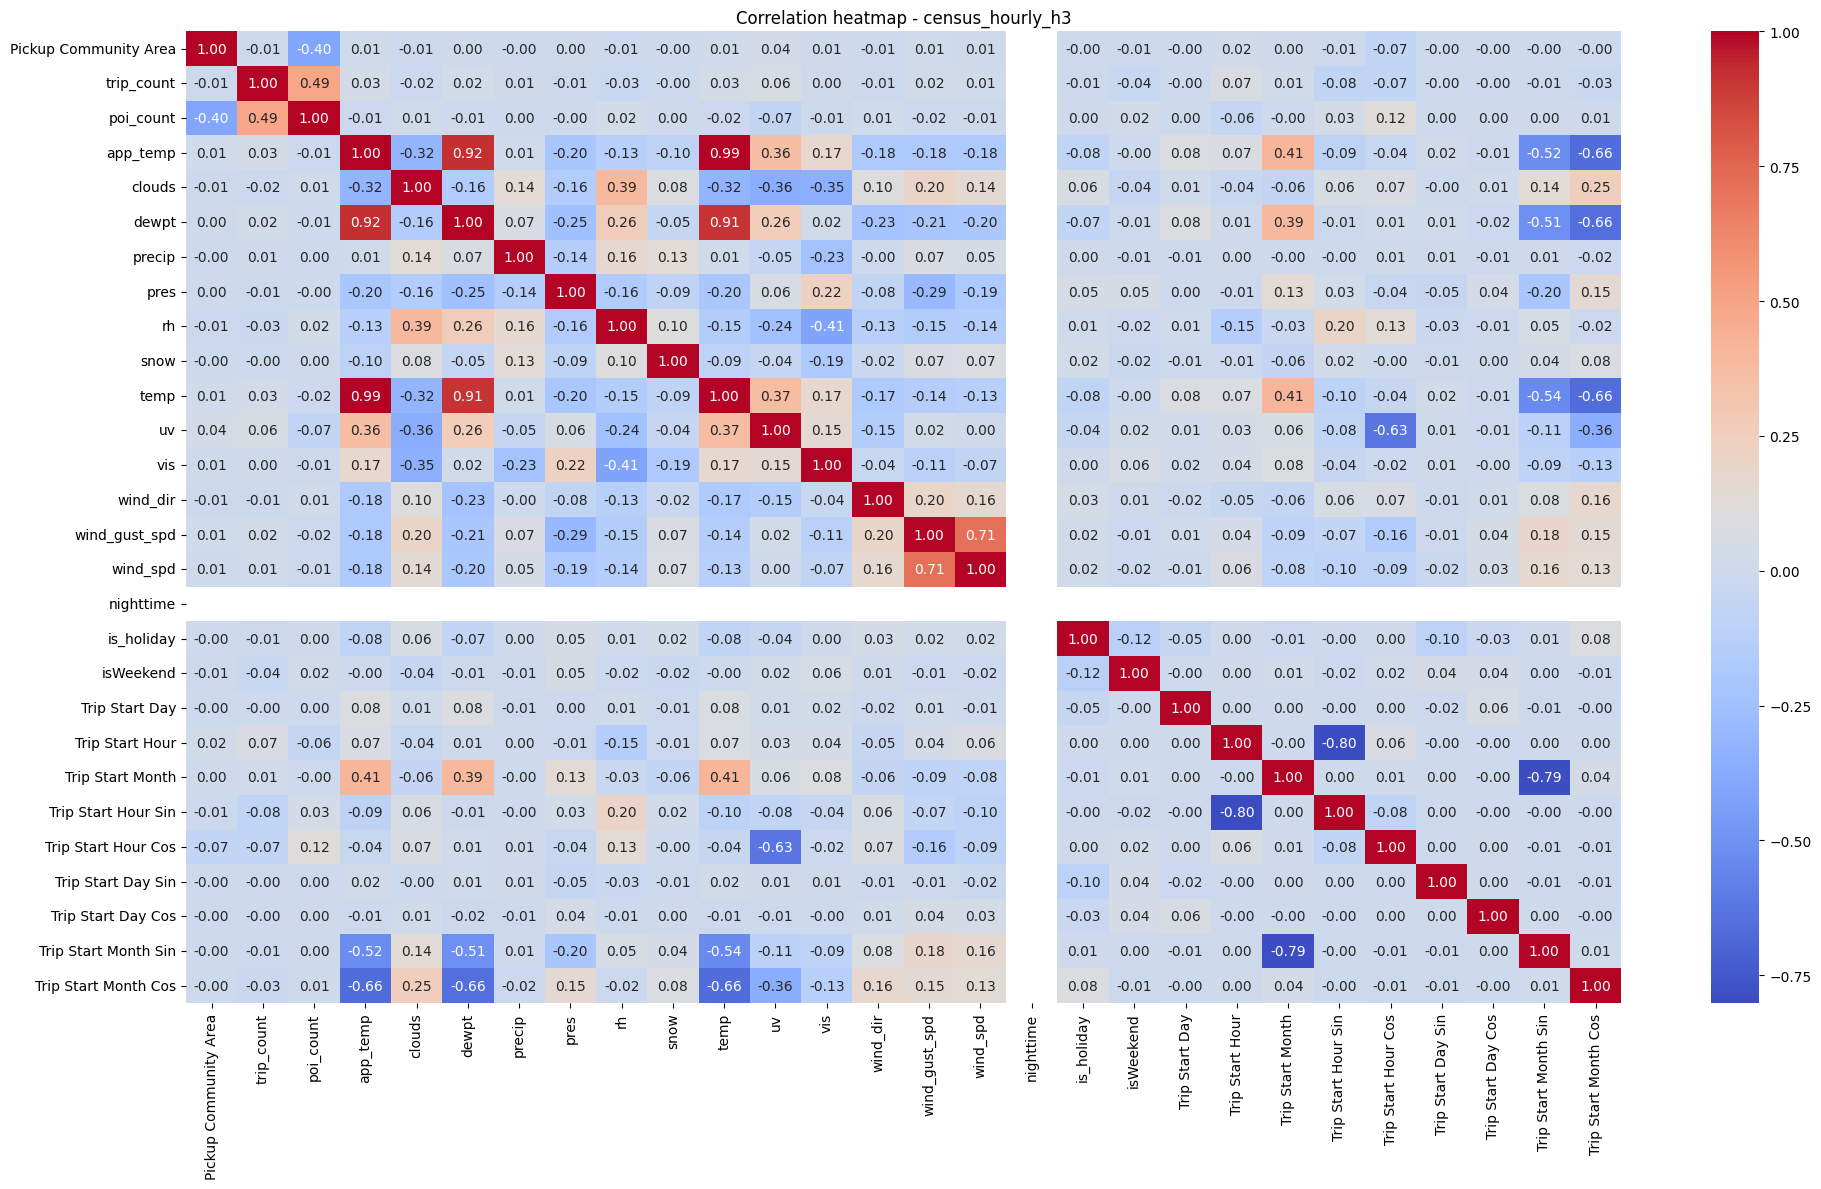

In [3]:
num_df = area_hourly_h3.select_dtypes(include=[np.number])
corr = num_df.corr(numeric_only=True)
plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation heatmap - census_hourly_h3')
plt.tight_layout()
plt.show()

In [4]:
drop_cols = ["Pickup Centroid Location", "Trip Hour", "dewpt", "app_temp", "nighttime"]
target_col = "trip_count"
h3_col = "pickup_h3_9"

def preprocess(df, drop_cols, target_col, h3_col, include_h3=True):
    df = df.drop(columns=drop_cols, errors='ignore')
    df = df.dropna(subset=[target_col])

    y = df[target_col]

    num_features = df.select_dtypes(include=[np.number]).drop(columns=[target_col], errors='ignore').columns.tolist()
    cat_features = [h3_col] if include_h3 and h3_col in df.columns else []

    used_features = num_features + cat_features
    X = df[used_features]

    transformers = [("num", StandardScaler(), num_features)]
    if cat_features:
        transformers.append(("h3", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features))

    preprocessor = ColumnTransformer(transformers)

    return X, y, preprocessor


def fit_model(X, y, preprocessor, model_stage):
    if model_stage == "linear":
        model = LinearSVR(max_iter=1000, tol=1e-4)
    elif model_stage == "rbf":
        model = make_pipeline(
            RBFSampler(gamma=0.1, n_components=500, random_state=42),
            SGDRegressor(max_iter=1000, tol=1e-3)
        )
    elif model_stage == "poly":
        model = make_pipeline(
            PolynomialCountSketch(degree=3, n_components=500, random_state=42),
            SGDRegressor(max_iter=1000, tol=1e-3)
        )
    else:
        raise ValueError(f"Unknown model_stage: {model_stage}")

    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X, y)
    return pipeline

def evaluate_model(pipeline, X_test, y_test):
  y_pred = pipeline.predict(X_test)
  return {
      "mse": mean_squared_error(y_test, y_pred),
      "mae": mean_absolute_error(y_test, y_pred),
      "r2": r2_score(y_test, y_pred)
  }


In [5]:
trained_models = {}
evaluation_results = {}

for name, df in datasets.items():
    print(f"Processing {name}...")
    if target_col not in df.columns:
        print(f"Skipping {name} — missing '{target_col}'")
        continue

    try:
        df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

        models = {}
        metrics = {}

        for kernel in ["linear", "rbf"]: #, "poly" don't include due to numerical instability
            include_h3 = kernel != "poly"

            X_train, y_train, preprocessor = preprocess(df_train.copy(), drop_cols, target_col, h3_col, include_h3)
            X_test, y_test, _ = preprocess(df_test.copy(), drop_cols, target_col, h3_col, include_h3)

            model = fit_model(X_train, y_train, preprocessor, kernel)
            models[kernel] = model
            metrics[kernel] = evaluate_model(model, X_test, y_test)

        trained_models[name] = models
        evaluation_results[name] = metrics

        print(f"Trained and evaluated models for {name}")
    except Exception as e:
        print(f"Error processing {name}: {e}")


Processing area_2hourly_h3...
Trained and evaluated models for area_2hourly_h3
Processing area_6hourly_h3...
Trained and evaluated models for area_6hourly_h3
Processing area_12hourly_h3...
Trained and evaluated models for area_12hourly_h3
Processing area_hourly_h3...
Trained and evaluated models for area_hourly_h3


In [6]:
rows = []
for dataset_name, kernels in evaluation_results.items():
    for kernel_name, scores in kernels.items():
        row = {
            "dataset": dataset_name,
            "kernel": kernel_name,
            **scores
        }
        rows.append(row)

metrics_df = pd.DataFrame(rows).sort_values(by=["dataset", "kernel"])

print("\nSVM Performance Comparison:\n")
print(metrics_df)


SVM Performance Comparison:

            dataset  kernel            mse         mae        r2
4  area_12hourly_h3  linear   60537.701646   48.408186  0.603274
5  area_12hourly_h3     rbf  103505.220449  170.714733  0.321692
0   area_2hourly_h3  linear    3051.682095   15.808166  0.592571
1   area_2hourly_h3     rbf    5494.791935   38.194429  0.266392
2   area_6hourly_h3  linear   18815.504782   34.795468  0.626004
3   area_6hourly_h3     rbf   37370.687949   97.941518  0.257182
6    area_hourly_h3  linear     934.545994    9.594726  0.580082
7    area_hourly_h3     rbf    1616.750281   21.622403  0.273548
